# Bitcoin Elliptic

Experiment on the [Bitcoin Elliptic](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) data set. Temporal graph where every timestep is a block of transactions. We want to classify fraudulent nodes (class 1). There are also a bunch of unlabeled nodes (class -1).

In [1]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Read dataset

In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data

# target to torch tensor
target_df = pd.read_csv("dataset/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

# make class binary
target_df["class"] = target_df["class"].replace("unknown", "-1")
target_df["class"] = target_df["class"].replace("2", "0")
target_df["class"] = pd.to_numeric(target_df["class"])
target = torch.tensor(target_df["class"].values)

# node features to torch tensor
x_df = pd.read_csv("dataset/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
id_df = x_df[0]
x_df = x_df.drop(columns=0) # drop id column
timestep_df = x_df[1]
x_df = x_df.drop(columns=1) # drop timestep column
x_tensor = torch.tensor(x_df.values).float()

# replace ids
id_df = pd.to_numeric(id_df)
id_df = id_df.reset_index()
id_df = id_df.rename(columns={"index":"New_ID"})
id_df = id_df.rename(columns={0:"Old_ID"})
id_dict = dict(zip(id_df["Old_ID"].values,id_df["New_ID"].values))

# edges to torch tensor
edges_df = pd.read_csv("dataset/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
edges_df["txId1"] = pd.to_numeric(edges_df["txId1"])
edges_df["txId2"] = pd.to_numeric(edges_df["txId2"])

# replace ids
edges_df["txId1"] = edges_df["txId1"].apply(lambda x: id_dict[x])
edges_df["txId2"] = edges_df["txId2"].apply(lambda x: id_dict[x])

edge_index = torch.LongTensor((edges_df["txId1"].values,edges_df["txId2"].values))

# timesteps
timesteps = torch.LongTensor(timestep_df.values)

# put together graph
data = Data(x=x_tensor, edge_index=edge_index, y=target)

data.num_classes = 2
data.time_steps = timesteps

print(data)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], num_classes=2, time_steps=[203769])


## Inspect data

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['figure.figsize'] = [15, 12]
font = {'size': 32}
matplotlib.rc('font', **font)
alpha = 1

for ts in [1,10,20,30,40,49]:
  y = data.y[data.time_steps <= ts].reshape(-1).detach().numpy()
  classes = np.unique(y)
  bins = np.append(classes, np.max(y)+1)

  hist = plt.hist(y, bins=bins, rwidth=0.8, color="#4363d8")
  print(hist)

  plt.xticks(classes+0.5, classes)
  plt.title(f"Class distribution - Bitcoin - Time step {ts}")
  plt.xlabel("Class")
  plt.ylabel("Number of node")
  plt.grid(True)

  plt.tight_layout()
  output_dir = "plots"
  os.makedirs(output_dir, exist_ok=True)
  plt.savefig(f"{output_dir}/bitcoin-class-dist-{ts}.png")
  plt.close()
  # plt.show()

(array([5733., 2130.,   17.]), array([-1,  0,  1,  2]), <BarContainer object of 3 artists>)
(array([45629., 11944.,   524.]), array([-1,  0,  1,  2]), <BarContainer object of 3 artists>)
(array([71873., 17118.,  1771.]), array([-1,  0,  1,  2]), <BarContainer object of 3 artists>)
(array([96382., 23951.,  2954.]), array([-1,  0,  1,  2]), <BarContainer object of 3 artists>)
(array([125012.,  32570.,   4021.]), array([-1,  0,  1,  2]), <BarContainer object of 3 artists>)
(array([157205.,  42019.,   4545.]), array([-1,  0,  1,  2]), <BarContainer object of 3 artists>)


# TEMP

In [4]:
from lib.data import split_dataset, split

time_steps = torch.unique(data.time_steps)

graphs = []

for ts in time_steps:
  print("ts: {}".format(ts))
  indices = torch.nonzero(torch.where(data.time_steps == ts, 1, 0))[:,0].tolist()

  ts_data = split(data, indices)

  # TODO: Retrieve test_indices only from current ts
  train_data, calibration_indices, test_indices = split_dataset(ts_data, test_frac=0.2, calibration_frac=0.2)
  graphs.append({
    "ts": ts,
    "data": ts_data,
    "train_data": train_data,
    "calibration_indices": calibration_indices,
    "test_indices": test_indices,
  })


ts: 1
ts: 2
ts: 3
ts: 4
ts: 5
ts: 6
ts: 7
ts: 8
ts: 9
ts: 10
ts: 11
ts: 12
ts: 13
ts: 14
ts: 15
ts: 16
ts: 17
ts: 18
ts: 19
ts: 20
ts: 21
ts: 22
ts: 23
ts: 24
ts: 25
ts: 26
ts: 27
ts: 28
ts: 29
ts: 30
ts: 31
ts: 32
ts: 33
ts: 34
ts: 35
ts: 36
ts: 37
ts: 38
ts: 39
ts: 40
ts: 41
ts: 42
ts: 43
ts: 44
ts: 45
ts: 46
ts: 47
ts: 48
ts: 49


graph is strongly connected component: False
graph is weakly connected component: False
graph has # weakly connected components: 49
graph has # isolated nodes: 0


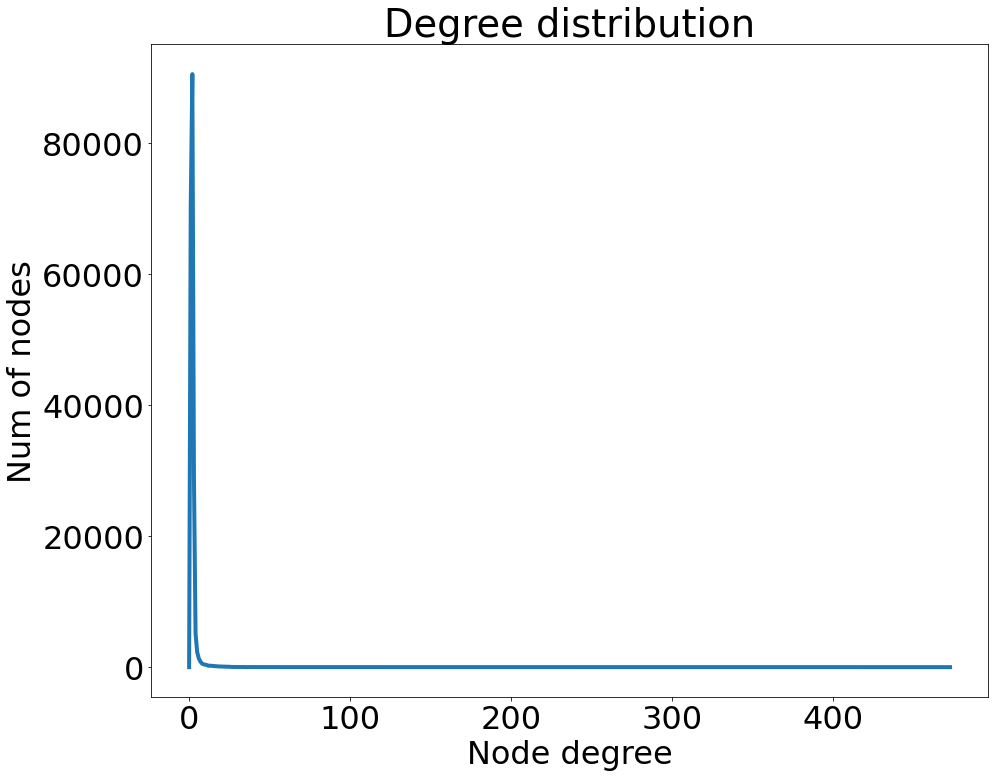

In [5]:
from lib import util

util.describe_graph(data)

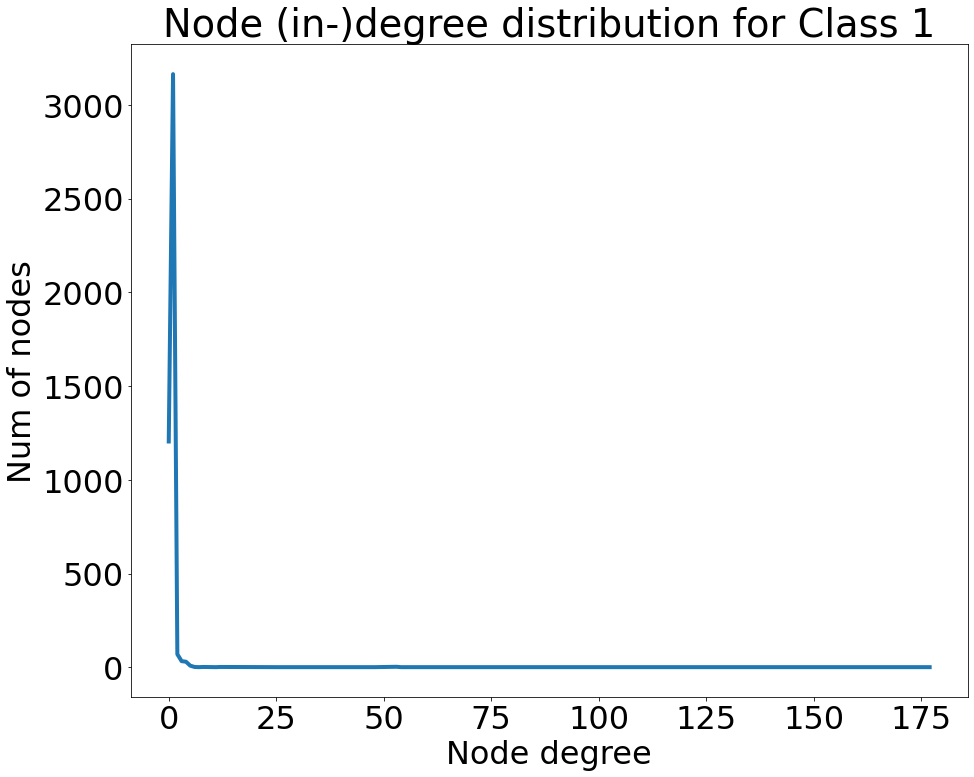

In [6]:
node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree

hist = nd[data.y == 1]

c1_degrees, c1_counts = torch.unique(hist, return_counts=True)

plt.plot(c1_degrees, c1_counts)
plt.title("Node (in-)degree distribution for Class 1")
plt.xlabel("Node degree")
plt.ylabel("Num of nodes")
plt.show()



## Split data set

In [7]:
from lib.data import split_dataset

train_data, calibration_indices, test_indices = split_dataset(data, 0.2, 0.2)

print("Train set: {}".format(train_data))
print("Calibration set size: {}".format(len(calibration_indices)))
print("Test set size: {}".format(len(test_indices)))

Train set: Data(x=[122262, 165], edge_index=[2, 84405], y=[122262])
Calibration set size: 40754
Test set size: 40753


## Inspect Train set

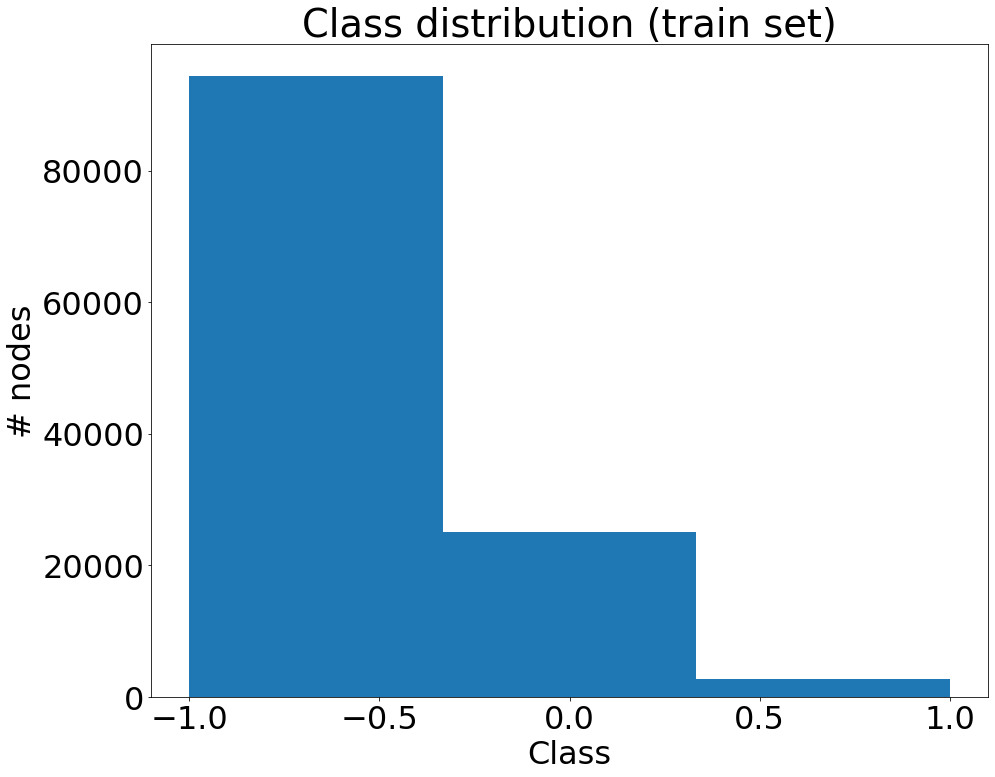

In [8]:
plt.title("Class distribution (train set)")
plt.hist(train_data.y.reshape(-1).detach().numpy(), 3)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: False
graph has # weakly connected components: 42695
graph has # isolated nodes: 26686


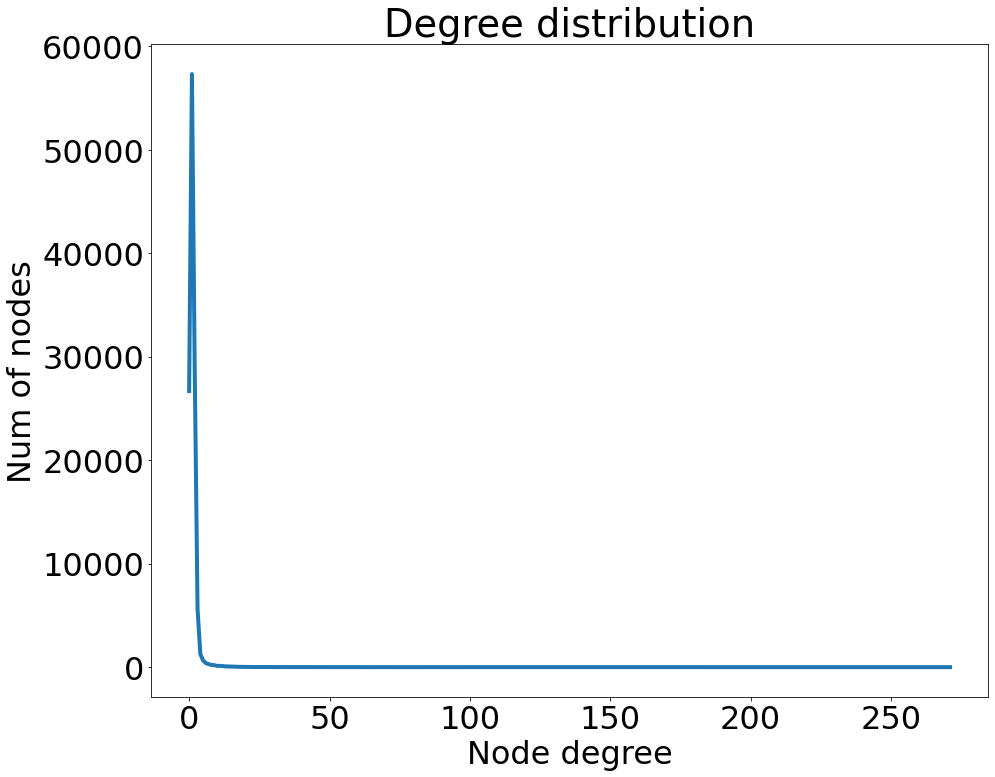

In [9]:
util.describe_graph(train_data)

## Inspect calibration data

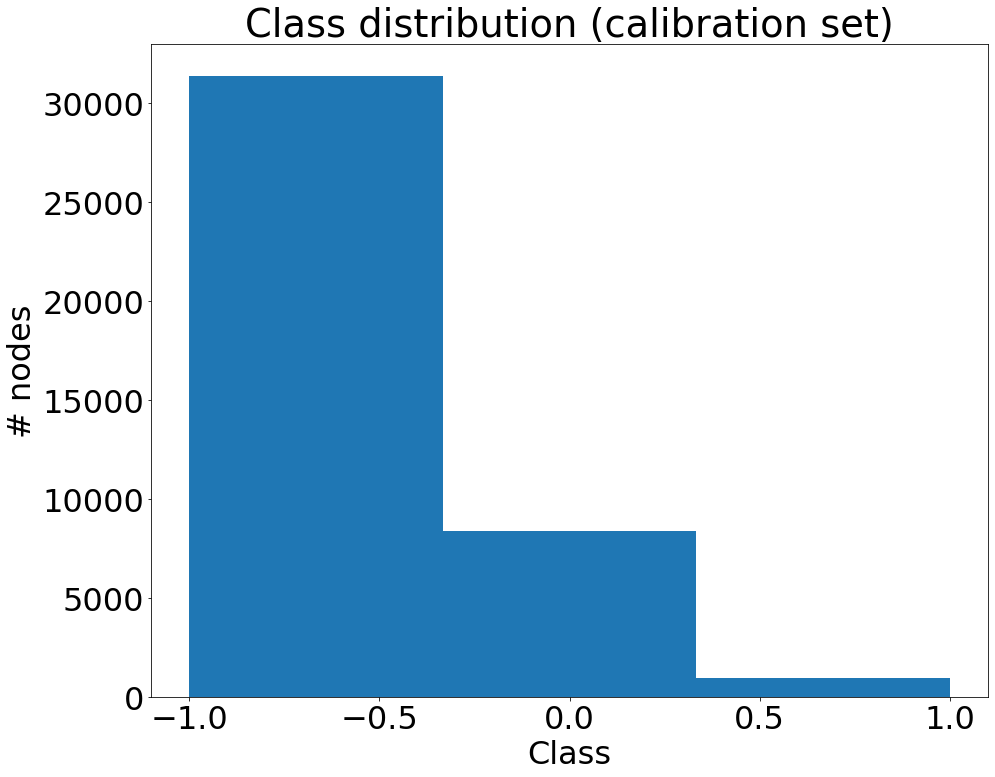

In [10]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[calibration_indices].reshape(-1).detach().numpy(), 3)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

## Inspect test data

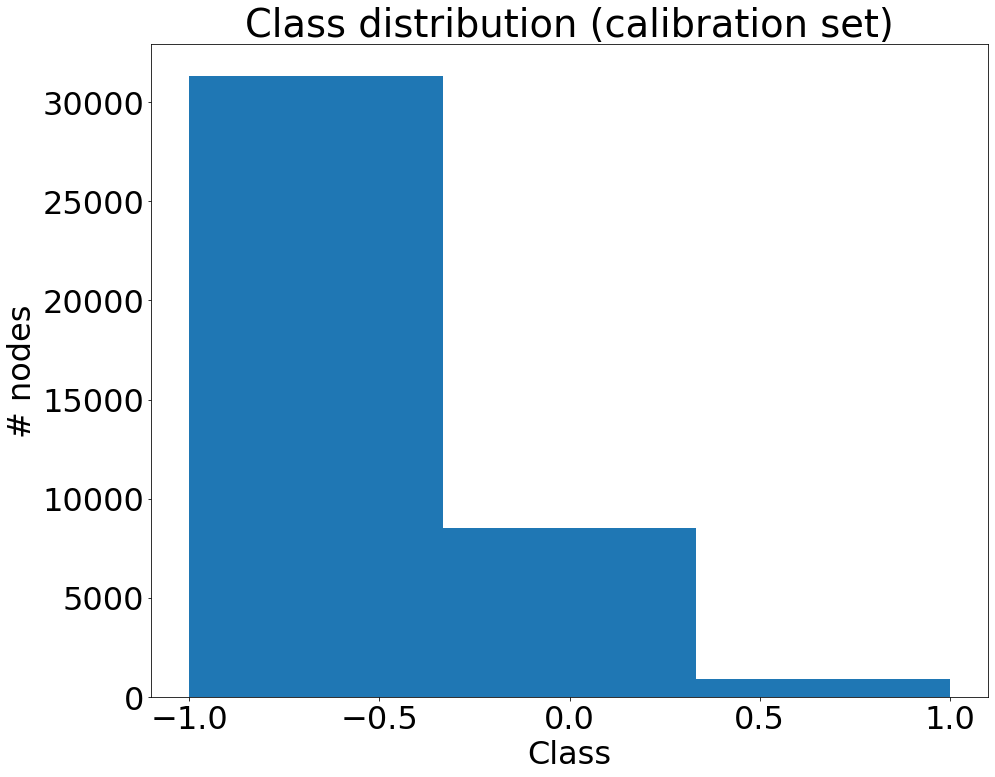

In [11]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[test_indices].reshape(-1).detach().numpy(), 3)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

# GraphSAGE model

In [12]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
    """
      sampling_size: number of neighbors to sample at each layer (list[int]).
    """
    super(GraphSAGE, self).__init__()

    self.num_layers = num_layers

    self.convs = torch.nn.ModuleList()
    self.bns = torch.nn.ModuleList()

    # input layer
    self.convs.append(SAGEConv(in_channels=input_dim, out_channels=hidden_dim, aggr="mean"))
    self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # hidden layers
    for _ in range(0, num_layers-1):
      self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim, aggr="mean"))
      self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # output layer
    self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=output_dim, aggr="mean"))

    self.softmax = torch.nn.LogSoftmax(dim=1)

    self.dropout = 0.1

    self.return_embeds = False

  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()

  def forward(self, x, adj_t):
    embedding = x
    for i, conv in enumerate(self.convs[:-1]):
      embedding = conv(x=embedding, edge_index=adj_t)
      embedding = self.bns[i](embedding)
      embedding = torch.nn.functional.relu(embedding)
      embedding = torch.nn.functional.dropout(embedding, p=self.dropout, training=self.training)
    
    # output layer
    embedding = self.convs[-1](x=embedding, edge_index=adj_t)

    node_class = self.softmax(embedding)

    if self.return_embeds:
      return node_class, embedding

    return node_class

  def train_model(self, data, optimizer, loss_fn):
    self.train()

    optimizer.zero_grad()
    
    out = self(data.x, data.edge_index)

    y_true = data.y.reshape(-1).detach()

    loss = loss_fn(out, y_true)

    loss.backward()
    optimizer.step()
  
  def predict(self, data):
    self.eval()
    
    if self.return_embeds:
        y_hat, embeddings = self(data.x, data.edge_index)
        return y_hat.clone().detach(), embeddings
        
    y_hat = self(data.x, data.edge_index)
    
    return y_hat.clone().detach()

  def set_return_embeds(self, return_embeds: bool):
    self.return_embeds = return_embeds


In [14]:
from lib.evaluation import get_binary_classification_performance

args = {
    "num_layers": 1,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 15,
    "batch_size": 128,
    "num_neighbors": [1],
    "max_stagnation": 15,
}

model = GraphSAGE(data.num_features, args["hidden_dim"], data.num_classes, args["num_layers"])


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

nll_loss = torch.nn.NLLLoss(weight=torch.tensor([0.2,1])) # negative log-likelihood
def custom_loss_fn(y_hat, y_true):
  known_class_indices = y_true != -1 # only look at nodes with known classes
  return nll_loss(y_hat[known_class_indices], y_true[known_class_indices])

loss_fn = custom_loss_fn

for epoch in range(1, 1 + args["epochs"]):
    print(f"Epoch: {epoch:02d}")
    loss = model.train_model(train_data, optimizer, loss_fn)
    
# evaluate
model.eval()

y_hat = model.predict(data)
y_hat = y_hat[test_indices]
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

y_true = data.y[test_indices].reshape(-1)

known_class_mask = y_true != -1
test_acc, test_f1_class_0, test_f1_class_1 = get_binary_classification_performance(y_hat[known_class_mask], y_true[known_class_mask])

print(f"Model found \n"
        f"Test acc: {100 * test_acc:.2f}%, "
        f"Test f1 (class 0): {100 * test_f1_class_0:.2f}%, "
        f"Test f1 (class 1): {100 * test_f1_class_1:.2f}%")

Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Model found 
Test acc: 90.88%, Test f1 (class 0): 94.78%, Test f1 (class 1): 64.10%


# Static K-means elbow curve

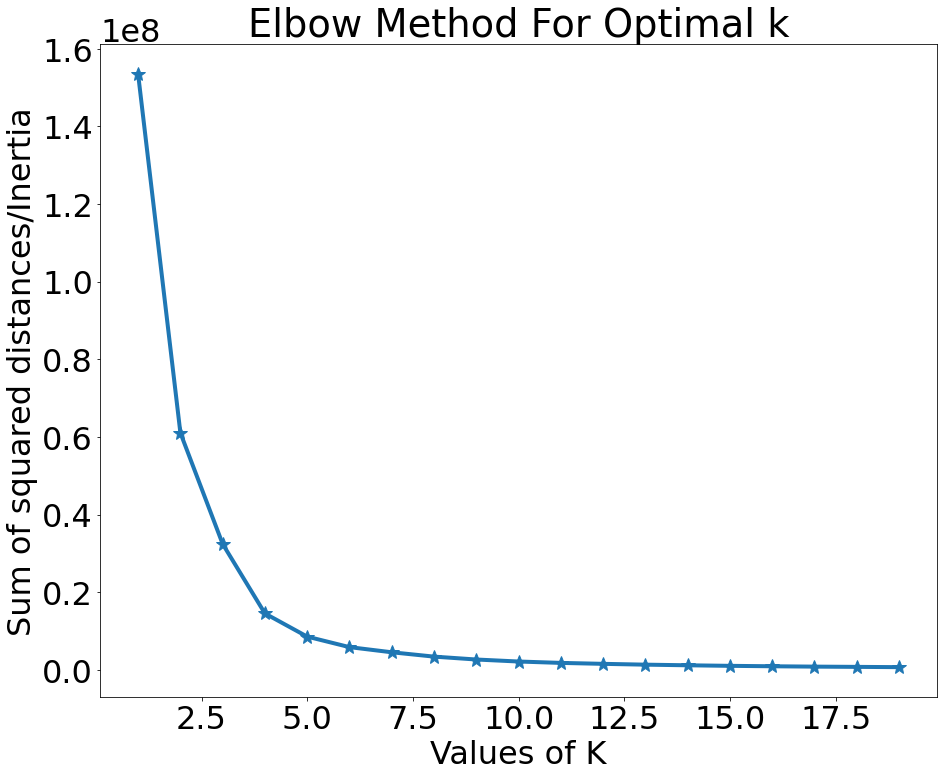

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

model.set_return_embeds(True)
_, embeds = model.predict(data)

Sum_of_squared_distances = []
K = range(1,20)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(embeds.detach().numpy())
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,"*-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

# K-Means with graphsage trained on only first time step

In [29]:
args = {
    "num_layers": 1,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 15,
    "batch_size": 128,
    "num_neighbors": [1],
    "max_stagnation": 15,
}

model = GraphSAGE(data.num_features, args["hidden_dim"], data.num_classes, args["num_layers"])


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

nll_loss = torch.nn.NLLLoss(weight=torch.tensor([0.2,1])) # negative log-likelihood
def custom_loss_fn(y_hat, y_true):
  known_class_indices = y_true != -1 # only look at nodes with known classes
  return nll_loss(y_hat[known_class_indices], y_true[known_class_indices])

loss_fn = custom_loss_fn

train_data = graphs[0]["train_data"]

for epoch in range(1, 1 + args["epochs"]):
    print(f"Epoch: {epoch:02d}")
    loss = model.train_model(train_data, optimizer, loss_fn)
    
# evaluate
model.eval()

y_hat = model.predict(data)
y_hat = y_hat[test_indices]
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

y_true = data.y[test_indices].reshape(-1)

known_class_mask = y_true != -1
test_acc, test_f1_class_0, test_f1_class_1 = get_binary_classification_performance(y_hat[known_class_mask], y_true[known_class_mask])

print(f"Model found \n"
        f"Test acc: {100 * test_acc:.2f}%, "
        f"Test f1 (class 0): {100 * test_f1_class_0:.2f}%, "
        f"Test f1 (class 1): {100 * test_f1_class_1:.2f}%")

Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Model found 
Test acc: 90.59%, Test f1 (class 0): 95.06%, Test f1 (class 1): 0.00%


In [73]:
import itertools

matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['figure.figsize'] = [30, 12]
font = {'size': 32}
matplotlib.rc('font', **font)

markers = itertools.cycle(['o', 'v', '^', 'X', 's', 'p', 'D'])
colors = itertools.cycle(['#e6194B', '#f58231', '#ffe119', '#3cb44b', '#e303fc', '#4363d8'])

model.set_return_embeds(True)

sums_of_sums = []

for graph in graphs:
  _, embeds = model.predict(graph["data"])

  Sum_of_squared_distances = []
  K = range(1,10)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(embeds.detach().numpy())
    Sum_of_squared_distances.append(kmeans.inertia_)
  sums_of_sums.append(np.sum(Sum_of_squared_distances))
  ts = graph["ts"]
  plt.plot(K,Sum_of_squared_distances,label=f"Time step {ts}", marker=next(markers), color=next(colors), ls="-")
plt.xlabel("K") 
plt.ylabel("Sum of squared distances") 
plt.title("Elbow Method For Optimal K - Bitcoin Elliptic - train once")
# plt.legend(ncol=3)
plt.grid(True)

plt.tight_layout()
plt.savefig(f"plots/Elbow method for optimal K - Bitcoin Elliptic - Train once.png")
plt.close()
# # plt.show()

plt.plot(range(0,49),sums_of_sums,marker="o",color="#4363d8",ls="-", label="GraphSAGE embeddings")
plt.xlabel("Time step") 
plt.ylabel("Sum of squared distances") 
plt.grid(True)
plt.title("Score for K-means clustering - Bitcoin Elliptic - train once")
plt.savefig(f"plots/Score for K-means clustering - Bitcoin Elliptic - train once.png")
plt.close()

In [54]:
num_nodes = []

for ts in range(1,50):
  nodes = data.y[data.time_steps == ts].reshape(-1).shape[0]
  num_nodes.append(nodes)

plt.plot(range(1,50),num_nodes,marker="o",color="#4363d8",ls="-", label="GraphSAGE embeddings")
plt.xlabel("Time step") 
plt.ylabel("New nodes") 
plt.grid(True)
plt.title("Number of nodes per time step - Bitcoin Elliptic")
plt.tight_layout()
plt.savefig(f"plots/Number of nodes per time step - Bitcoin Elliptic.png")
plt.close()
# plt.show()

# PCA

In [71]:
from sklearn.decomposition import PCA

_, embeds = model.predict(data)

matplotlib.rcParams['lines.markersize'] = 14

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeds.detach().numpy())

plt.scatter(principalComponents[data.time_steps > 2,0], principalComponents[data.time_steps > 2,1], marker="o", c="#4363d8", label=f"Time step > 2", alpha=0.2)
plt.scatter(principalComponents[data.time_steps == 2,0], principalComponents[data.time_steps == 2,1], marker="v", c="#ffe119", label=f"Time step 2", alpha=0.4)
plt.scatter(principalComponents[data.time_steps == 1,0], principalComponents[data.time_steps == 1,1], marker="X", c="#e6194B", label=f"Time step 1", alpha=0.2)

plt.xscale("log")
plt.legend()
plt.grid(True)
plt.title("Principal Component Analysis of GraphSAGE embeddings - Bitcoin Elliptic")
plt.tight_layout()
plt.savefig(f"plots/Principal Component Analysis of GraphSAGE embeddings - Bitcoin Elliptic.png")
plt.close()